# Module 2/3 Final Project Submission

* Student name: Bronwen Cohn-Cort
* Student pace: Self-paced
* Scheduled project review date/time: March 2, 16:00 EST
* Instructor name: Jeff
* Link to blog post: https://bronwencc.github.io/heat-maps_carry_insight

In [1]:
#all import statements in these few cells
import pandas as pd
import numpy as np
np.random.seed(25)#so this notebook's conclusions can be replicable

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn")

In [22]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import inspect
import sqlite3

In [2]:
from scipy import stats

In [ ]:
import statsmodels.api as sm

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [8]:
from itertools import combinations

In [3]:
import csv

In [1]:
#creating folder for .CSV files and graphs
import os

current = os.curdir
newfolders = ['files','graphs']
for newfolder in newfolders:
    newpath = os.path.join(current,newfolder)
    if not os.path.exists(newpath):
        os.makedirs(newpath)

## Preliminary Exploration of Dataset

Schema for the Northwind database:

<img src='Northwind_ERD.png'>

In [23]:
#SQLite block setting up for importing the data, looking at table names
myengine = create_engine("sqlite:///Northwind_small.sqlite")
inspector = inspect(myengine)

print(inspector.get_table_names())#check the table names in Northwind

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'OrderDetail', 'Orders', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


Most table names are spelled differently than in the provided schema: "Category", "Customer", "CustomerDemographic", "Employee", "EmployeeTerritory", "Order", "OrderDetail", "Product", "Shipper", "Supplier", and "Territory".

## Hypothesis 1 (Given): Discounts affecting Product Quantity
Null hypothesis: discounted has a lower or the same mean as nodiscount

$H_0$: $Quantity_d$ $\le$ $Quantity_f$ ($d$ is discounted, $f$ is full price)

Alternative hypothesis: discounted has a higher mean than nodiscount

$H_1$: $Quantity_d$ $\gt$ $Quantity_f$

According to the schema, the discount amount is in the OrderDetail table, along with the quantity of a product.

In [2]:
conn = myengine.connect() #connecting to engine
orderDetails = conn.execute('''SELECT * FROM OrderDetail;''').fetchall()

#make list of column names
cols = inspector.get_columns("OrderDetail")
ordDetCols = []
for col in cols:
    ordDetCols.append(col['name'])
ordDetCols

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [3]:
#putting OrderDetail table into pandas DataFrame
ordDetdf = pd.DataFrame(orderDetails, columns=ordDetCols)
#saving DataFrame as CSV file to more easily access subsequently
ordDetdf.to_csv(path_or_buf="files/OrderDetail.csv")
ordDetdf.head(3)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0


In [4]:
#code to get CSV file back into DataFrame
ordDetdf = pd.read_csv("files/OrderDetail.csv")

In [5]:
#looking at aspects of the DataFrame with .info()
ordDetdf.drop(columns=["Unnamed: 0"], inplace=True)
ordDetdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [26]:
ordDetdf.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


None of the values are null, but since Discount and Quantity are the relevant columns for this hypothesis, I will look at them at another level of detail.

In [6]:
#frequencies of the unique values in Discount
ordDetdf.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Since Discount appears to be a discrete variable, I will drop the values that appear 3 or fewer times (.01 to .06 at intervals of .01, excluding .05).

In [7]:
#Dropping all very infrequent discount values
appearances=3+2+(1*3) #8
print(f"The least frequent discount values appear in {round(appearances/2155*100,2)}% of the records.")
#replacing the values that appear a total of 8 times as NaN
ordDetdf.Discount = ordDetdf["Discount"].replace(to_replace=[0.01,0.02,0.03,0.04,0.06],value=np.nan)

The least frequent discount values appear in 0.37% of the records.


In [8]:
#having now changed to NaN values, can easily use dropna to remove those rows
ordDetdf.dropna(axis='index',how='any',inplace=True)
ordDetdf.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000
mean,10657.819748,40.805776,26.203987,23.895203,0.056265
std,240.474433,22.148297,29.855453,19.009580,0.083586
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10450.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10861.000000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [9]:
ordDetdf.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

The Discount values have been adjusted accordingly.

A check for null values:

In [10]:
ordDetdf.isna().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

The appropriate records have been removed from the DataFrame, as there are now 2147 records and no Null values in the DataFrame.  The following will now convert the Discount column to a categorical type and then to dummy columns for each value: 0.00, 0.05, 0.10, 0.15, 0.20 and 0.25.

In [11]:
#change Discount to categorical variables
ordDetdf["Discount"]=ordDetdf.Discount.astype("category")
#create dummy columns
dummies = pd.get_dummies(ordDetdf["Discount"],prefix="disc")
#new DataFrame has Id, target (Quantity) and variable (Discount)
newdf = ordDetdf.drop(axis='columns',columns=["OrderId","ProductId","UnitPrice","Discount"])
#add dummy columns to a newer dataframe
disc_df = pd.concat([newdf, dummies], axis=1)
disc_df.head()

,Id,Quantity,disc_0.0,disc_0.05,disc_0.1,disc_0.15,disc_0.2,disc_0.25
0,10248/11,12,1,0,0,0,0,0
1,10248/42,10,1,0,0,0,0,0
2,10248/72,5,1,0,0,0,0,0
3,10249/14,9,1,0,0,0,0,0
4,10249/51,40,1,0,0,0,0,0


I will now create and save a new CSV file that consists of only the Quantity, Id and dummy Discount columns.

In [19]:
#saving to a CSV file
disc_df.to_csv(path_or_buf="files/DiscountDummies.csv")

In [3]:
disc_df = pd.read_csv("files/DiscountDummies.csv")
disc_df.drop(columns=["Unnamed: 0"], inplace=True)
disc_df.head()

,Id,Quantity,disc_0.0,disc_0.05,disc_0.1,disc_0.15,disc_0.2,disc_0.25
0,10248/11,12,1,0,0,0,0,0
1,10248/42,10,1,0,0,0,0,0
2,10248/72,5,1,0,0,0,0,0
3,10249/14,9,1,0,0,0,0,0
4,10249/51,40,1,0,0,0,0,0


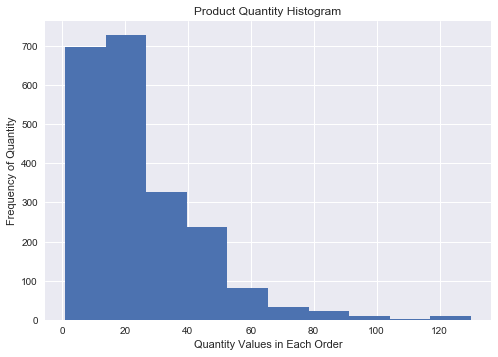

In [24]:
#plotting a histogram of Quantity values
plt.hist(disc_df.Quantity)
plt.title("Product Quantity Histogram")
plt.ylabel("Frequency of Quantity")
plt.xlabel("Quantity Values in Each Order")
plt.savefig("graphs/products.png")
plt.show()

The histogram shows most of Quantity is 30 or less, resulting in a somewhat left-skewed distribution.  In order to do an effect size calculation with Cohen's *d*, the data needs to be in a normal distribution.

C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


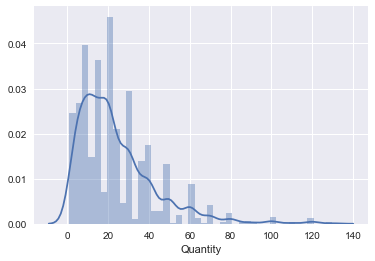

In [13]:
sns.distplot(disc_df.Quantity)

The Seaborn Distplot similarly shows a skew to the left, with the most frequent bucket or bin being about 20.

#### Degree of Effect
To figure out how much of an effect, I can use SciPy to measure the effect size between the sales that had zero discount and nonzero discounts.

In [8]:
#creating new dataframe with Quantity and a boolean Discount value
newdf = pd.concat([disc_df.Quantity,disc_df["disc_0.0"]],axis=1)
newdf.rename(columns={"disc_0.0":"NoDiscount"}, inplace=True) #disc_0.0 dummy renamed to NoDiscount: 1 meaning zero discount
newdf.head()

,Quantity,NoDiscount
0,12,1
1,10,1
2,5,1
3,9,1
4,40,1


In [9]:
#create discounted and non-discounted lists of data from the dataframe
discounted=[x for x, y in zip(newdf["Quantity"], newdf["NoDiscount"]) if y==0]
nodiscount=[x for x, y in zip(newdf["Quantity"], newdf["NoDiscount"]) if y==1]

In [17]:
#A 1 means there is no discount, while a 0 means there is a discount.
newdf.NoDiscount.value_counts()

1    1317
0     830
Name: NoDiscount, dtype: int64

In [18]:
print(f"There are {len(discounted)} products with a discount and {len(nodiscount)} without.")

#There are the same number of records, just now split into two lists of Quantity:
len(discounted)+len(nodiscount)==len(newdf)

There are 830 products with a discount and 1317 without.


True

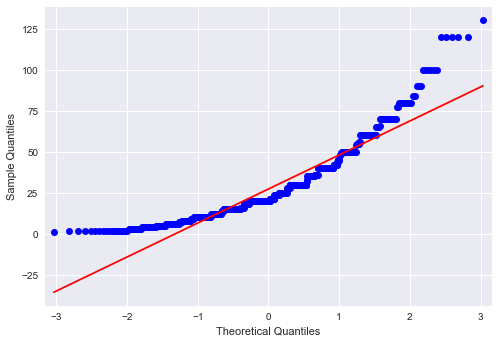

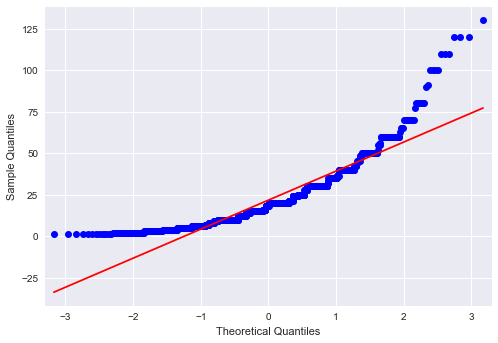

In [19]:
#plotting both lists to see normality with QQ plots
for each in [np.array(discounted), np.array(nodiscount)]:
    sm.qqplot(each, line='s')

It looks as though both follow a similar pattern, but are most different from the normal distribution at the extremes.

Next, I'll use the Kolmogorov-Smirnov Test to see how different from normal the discounted and non-discounted data are.

In [20]:
for each in [discounted, nodiscount]:
    print(stats.kstest(each,'norm'))

KstestResult(statistic=0.9760450487747123, pvalue=0.0)
KstestResult(statistic=0.9673789492970751, pvalue=0.0)


Since the `kstest` results both have a p-value of 0, the null hypothesis (that `discounted`/`nodiscount` is a normal distribution) is rejected and so with the p-value below 0.05, I can say the two datasets are not normally distributed.

I can use the `rvs` method to generate a random sample from the population distributions, and then calculate the difference between the distribution means.  Using the Central Limit Theorem to look at the sample distribution of sample means gives an approximate normal distribution to compare averages and p-values.

*Credit to arseniyturin on GitHub for inspiring me to use Cohen's $d$ statistic and a bootstrap method to look at effect size.*

In [18]:
#get a normally distributed sample by resampling
def resample(values):#a list of values to be resampled from
    dist=[] 
    for j in range(50):#loop to get 50 means for the sample-created distribution
        selection=[]#selection to store the random sample of 20 items from values
        for i in range(20):#loop to get 20 values for a sample
            val = np.random.choice(values)#take a sample
            selection.append(val)
        dist.append(np.mean(selection))#find the sample's mean and add it to new distribution
    return dist#returning the distribution of sample means

In [27]:
#create normally distributed lists of sample means
sample_disc = resample(discounted)
sample_nodisc = resample(nodiscount)

In [28]:
#make the normalized resampled means into a normal continuous random variable
norm_discounted = scipy.stats.norm(np.mean(sample_disc), np.std(sample_disc))
norm_nodiscount = scipy.stats.norm(np.mean(sample_nodisc), np.std(sample_nodisc))

In [29]:
#take a random sample from the normal continuous random variable of sample means:
disc_avg_sample = norm_discounted.rvs(1000)
nodisc_avg_sample = norm_nodiscount.rvs(1000)

However, Welch's t test and `ttest_ind` do not require normally distributed samples, so I will conduct both with the un-resampled variables `discounted` and `nodiscount`.  The `ttest_ind` is a two-tailed test so I divide its resulting p-value by 2 to get the p-value for a one-tailed test, my hypotheses being:

$H_0$: $Quantity_d$ $\le$ $Quantity_n$ ($d$ is discounted, $n$ is nodiscount)

$H_1$: $Quantity_d$ $\gt$ $Quantity_n$

In [7]:
#two-tailed t-test so divide by 2 to get one-tailed test's p-value
stats.ttest_ind(discounted, nodiscount,equal_var=False)[1]/2#look at difference in means between them
#Welch's t-test, assuming variance is not equal

5.0256277704215826e-11

Welch's t test doesn't need normal distributions if sample sizes are larger than 30.  I will use a one-tailed test since the null hypothesis is that discounted `Quantity`'s mean is less than or equal to full price `Quantity`'s mean.

In [27]:
#function for Welch's t test
def welcht(firs, secs):#assuming both samples are numpy arrays
    '''
    Performs Welch's t test on two samples.
    
    Args
        firs (numpy array): first sample to test
        secs (numpy array): second sample to test
        
    Returns
        (float): Welch's test statistic
    '''
    numerator = firs.mean()-secs.mean()
    
    n1 = firs.size
    n2 = secs.size
    denominator = np.sqrt(firs.var(ddof=1)/n1 + secs.var(ddof=1)/n2)
    
    return numerator/denominator

In [7]:
#function for effective degrees of freedom
def effectdof(fir, sec): #assuming both samples are numpy arrays
    s1 = fir.var(ddof=1) #ddof is 0 by default but degrees of freedom
    s2 = sec.var(ddof=1) #should be n-1, not n-0, so need to specify
    n1 = fir.size
    n2 = sec.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

In [8]:
#function to calculate probability of t being less than or equal to the data
def onetail(firstdata, secdata):
    ttest = welcht(firstdata, secdata)
    edof = effectdof(firstdata,secdata)
    return 1 - stats.t.cdf(ttest, edof)

In [16]:
#these functions defined above use the format of numpy arrays
discarr = np.array(discounted)
ndisarr = np.array(nodiscount)

NameError: name 'discounted' is not defined

In [18]:
onetail(discarr,ndisarr)

5.02563546334045e-11

Since the p value is very much less than 0.05, the null hypothesis can be rejected and I can say that there is a significant difference between discounted and non-discounted values in quantity.  Specifically, I can say that the discounted quantity's mean is higher.

I'll look at Cohen's $d$ statistic to show the magnitude of difference between the discounted and non-discounted items.

In [30]:
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()#difference between means
    var1 = group1.var()#variances
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)
    
    #calculate the pooled threshold for the denominator
    pooled_var = (n1*var1 + n2*var2)/(n1 + n2)
    
    #calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [31]:
Cohen_d(disc_avg_sample, nodisc_avg_sample)

1.1036038228729146

Cohen's $d$ statistic shows there is a large effect between the discounted and non-discounted items.

### Differences Between Discount Amounts
The next part of the question asked about whether there was an effect size between the different levels of discount.

In [32]:
disc_df.head()

,Id,Quantity,disc_0.0,disc_0.05,disc_0.1,disc_0.15,disc_0.2,disc_0.25
0,10248/11,12,1,0,0,0,0,0
1,10248/42,10,1,0,0,0,0,0
2,10248/72,5,1,0,0,0,0,0
3,10249/14,9,1,0,0,0,0,0
4,10249/51,40,1,0,0,0,0,0


In [4]:
#separate DataFrame into lists of discount levels for .05, .1, .15, .2, .25
discount05=[x for x, y in zip(disc_df["Quantity"], disc_df["disc_0.05"]) if y==1]
discount10=[x for x, y in zip(disc_df["Quantity"], disc_df["disc_0.1"]) if y==1]
discount15=[x for x, y in zip(disc_df["Quantity"], disc_df["disc_0.15"]) if y==1]
discount20=[x for x, y in zip(disc_df["Quantity"], disc_df["disc_0.2"]) if y==1]
discount25=[x for x, y in zip(disc_df["Quantity"], disc_df["disc_0.25"]) if y==1]

In [5]:
#creating pairs of discount values to compare each to each other
disc_lists = [discount05, discount10, discount15, discount20, discount25]

In [6]:
#creating a complementary percentage list to use as names
name_list = ["5","10","15","20","25"]

In [10]:
name_pairlist = []
namepairs = combinations(name_list, r=2)
for pair in namepairs:
    print(pair)
    name_pairlist.append(pair)

('5', '10')
('5', '15')
('5', '20')
('5', '25')
('10', '15')
('10', '20')
('10', '25')
('15', '20')
('15', '25')
('20', '25')


Now I will use a series of pairwise two-tailed tests to find the significance of each pair of discount amounts being compared.  The null hypothesis is that the mean of quantity for discount A is equal to that of the quantity for discount B.  The alternative hypothesis is that they are not equal. These are the hypotheses for each pairing combination.

In [38]:
#creating the corresponding combinations of discounts' Quantity
disc_pairs = list(combinations(disc_lists, r=2))

In [20]:
#two-tailed comparison would be the p-value*2 from onetail()
for idx, disc_pair in enumerate(disc_pairs):
    firstarr = np.array(disc_pair[0])
    secondarr = np.array(disc_pair[1])
    #multiplying by 2 gives the value for a two-tailed test
    pval = stats.ttest_ind(firstarr, secondarr,equal_var=False)# onetail() * 2
    names = name_pairlist[idx]
    print(f"The significance comparing {names[0]}% and {names[1]}% discounts is {pval}")

0
Ttest_indResult(statistic=1.209941058797434, pvalue=0.22710466225198522)
The significance comparing 5% and 10% discounts is 0
1
Ttest_indResult(statistic=-0.15907926596432054, pvalue=0.873701937770792)
The significance comparing 5% and 15% discounts is 0
2
Ttest_indResult(statistic=0.4470597476296268, pvalue=0.6551134299813659)
The significance comparing 5% and 20% discounts is 0
3
Ttest_indResult(statistic=-0.09976173385499833, pvalue=0.9205932482537716)
The significance comparing 5% and 25% discounts is 0
4
Ttest_indResult(statistic=-1.3556023920391185, pvalue=0.17616507980479174)
The significance comparing 10% and 15% discounts is 0
5
Ttest_indResult(statistic=-0.8162459699699015, pvalue=0.414945941918507)
The significance comparing 10% and 20% discounts is 0
6
Ttest_indResult(statistic=-1.3140624458315409, pvalue=0.1897558400462687)
The significance comparing 10% and 25% discounts is 0
7
Ttest_indResult(statistic=0.607539367319673, pvalue=0.5439367225420654)
The significance comp

The p-values for all of the pairwise comparisons are over 0.05, so the null hypothesis cannot be rejected and so there are no significant differences between any levels of discount.

In [96]:
for idx, disc_pair in enumerate(disc_pairs):
    
    smallBreak = (0.2+0.5)/2
    largeBreak = (0.5+0.8)/2
    
    fir_pair = np.array(disc_pair[0])
    sec_pair = np.array(disc_pair[1])
    d = abs(Cohen_d(fir_pair,sec_pair))
    
    if d<=smallBreak: # around 0.2 is a small effect size
        adjective="small"
    elif d<=largeBreak: # around 0.5 is a medium effect size
        adjective = "medium"
    else: # around 0.8 is a large effect size
        adjective = "large"
    
    names = name_pairlist[idx]
    
    print(f"The {adjective} effect size between {names[0]}% and {names[1]}% discounts is {d}")

The small effect size between 5% and 10% discounts is 0.12812673570489413
The small effect size between 5% and 15% discounts is 0.01722956211794838
The small effect size between 5% and 20% discounts is 0.04778093149327345
The small effect size between 5% and 25% discounts is 0.01081731590086831
The small effect size between 10% and 15% discounts is 0.14978635299812654
The small effect size between 10% and 20% discounts is 0.08927460012878101
The small effect size between 10% and 25% discounts is 0.14559055098817159
The small effect size between 15% and 20% discounts is 0.06844944375575103
The small effect size between 15% and 25% discounts is 0.006934572866815086
The small effect size between 20% and 25% discounts is 0.06261472101123484


The largest effect size is between 10% and 15%, which is still below 0.2 and considered a small effect.  Meanwhile, the lowest *d* value is found when comparing 15% and 25%, which would be rounded to zero, even at two decimal places.

These results indicate there is little-to-no difference within the values of the discount that impacts the quantity of products sold.

Even so, none of these results are significant, as determined by the previous two-tailed test.

## Hypothesis 2: Cold weather (meteorological winter) commands higher shipping prices

I will now consider the table containing shipping costs, shipping companies and the date of when an order was placed.  I would need to control for the weight, distance and shipping method also affecting shipping costs, but weight is not available and distance and shipping method are likely linked.  For instance, a longer distance may be sent by air and a shorter distance by truck.  Some of this information is beyond the scope of this project, so I will just compare the effect sizes of dates (categorized by season) to see whether there how much difference there is between them.
Hypothesis 3 compares the shipping companies.

$H_0$: $Freight_w$ $\le$ $Freight_n$ ($w$ is winter and $n$ is other months)

$H_1$: $Freight_w > Freight_n$

In [39]:
print(inspector.get_table_names())#check the table names

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'OrderDetail', 'Orders', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


So I will take the following variables from the "Orders" table: ShippedDate, ShipVia, Freight, ShipRegion and OrderID.

In [7]:
#make list of column names
cols = inspector.get_columns("Order")
ordCols = []
for col in cols:
    ordCols.append(col['name'])
ordCols

['Id',
 'CustomerId',
 'EmployeeId',
 'OrderDate',
 'RequiredDate',
 'ShippedDate',
 'ShipVia',
 'Freight',
 'ShipName',
 'ShipAddress',
 'ShipCity',
 'ShipRegion',
 'ShipPostalCode',
 'ShipCountry']

In [8]:
#creating list of selected, relevant column names
myOrdCols=[ordCols[0]]
for i in ordCols[5:8]:
    myOrdCols.append(i)
myOrdCols.append(ordCols[-3])
myOrdCols.append(ordCols[-1])
myOrdCols

['Id', 'ShippedDate', 'ShipVia', 'Freight', 'ShipRegion', 'ShipCountry']

In [35]:
#Order is a protected keyword part of ORDER BY in SQL, so I need to change the table name
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()
c.execute('''ALTER TABLE 'Order' RENAME TO 'Orders';''')
Orders = c.execute('''SELECT Id, ShippedDate, ShipVia, Freight, ShipRegion, ShipCountry FROM Orders''').fetchall()

In [10]:
#putting Order table's selected columns into pandas DataFrame
ordersdf = pd.DataFrame(Orders, columns=myOrdCols)

#saving DataFrame as .CSV file to more easily access later
ordersdf.to_csv(path_or_buf="files/Orders.csv")
ordersdf.head(3)

,Id,ShippedDate,ShipVia,Freight,ShipRegion,ShipCountry
0,10248,2012-07-16,3,32.38,Western Europe,France
1,10249,2012-07-10,1,11.61,Western Europe,Germany
2,10250,2012-07-12,2,65.83,South America,Brazil


In [41]:
#code to get CSV file back into DataFrame
ordersdf = pd.read_csv("files/Orders.csv")
ordersdf.drop(columns=["Unnamed: 0"], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 6 columns):
Id             830 non-null int64
ShippedDate    809 non-null object
ShipVia        830 non-null int64
Freight        830 non-null float64
ShipRegion     830 non-null object
ShipCountry    830 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 39.0+ KB


In [ ]:
#convert dates to datetime objects
ordersdf.ShippedDate = pd.to_datetime(ordersdf.ShippedDate)
ordersdf.info()

In [42]:
#look at frequency and how many different types of ShipRegion there are
ordersdf.ShipRegion.value_counts()

Western Europe     276
North America      152
South America      145
British Isles       75
Southern Europe     64
Northern Europe     55
Central America     28
Scandinavia         28
Eastern Europe       7
Name: ShipRegion, dtype: int64

I will add a new binary column for Northern or Southern Hemisphere.  South America is the only region located in the Southern Hemisphere, so I will just check for whether `ShipRegion` is South America or not.  Almost all countries in Central America are in the Northern Hemisphere.

In [4]:
#creating column for hemisphere: 1 if Northern, 0 if Southern
ordersdf["Hemisphere"] = [0 if region == "South America" else 1 for region in ordersdf.ShipRegion]

NameError: name 'ordersdf' is not defined

I will then create another pandas Series of seasons based on the hemisphere and the date, using meteorological dates (not astronomical) to determine the seasons: March 1, June 1, September 1 and December 1.

In [48]:
#function to classify seasons as numbers 1,2,3,4
def which_season(month, hemisphere):#month is int 1-12, hemisphere is a boolean: 0 if Southern, 1 for Nothern
    if hemisphere: #if Northern hemisphere
        if 3<=month<6: #between March 1 and June 1, including March, excluding June
            return 1 #1 for Spring
        elif (6<=month<9):
            return 2 #2 for Summer
        elif 9<=month<12:
            return 3
        else:
            return 4
    else:#if Southern Hemisphere
        if 3<=month<6: #between March 1 and June 1
            return 3 #3 for Autumn
        elif 6<=month<9:
            return 4 #4 for Winter
        elif 9<=month<12: #between September 1 and December 1
            return 1 #1 for Spring
        else:
            return 2

In [49]:
#create column for seasons based on hemisphere and shipping date
ordersdf["Season"] = [which_season(date.month, hemi) for date, hemi in zip(ordersdf.ShippedDate, ordersdf.Hemisphere)]
ordersdf.head()

,Id,ShippedDate,ShipVia,Freight,ShipRegion,ShipCountry,Hemisphere,Season
0,10248,2012-07-16,3,32.38,Western Europe,France,1,2
1,10249,2012-07-10,1,11.61,Western Europe,Germany,1,2
2,10250,2012-07-12,2,65.83,South America,Brazil,0,4
3,10251,2012-07-15,1,41.34,Western Europe,France,1,2
4,10252,2012-07-11,2,51.30,Western Europe,Belgium,1,2


July (7) is summer (2) in the Nothern Hemisphere and winter (4) in the Southern Hemisphere so we can see that the function and new columns were created as expected.

I will now look at the frequency of the seasons graphically.

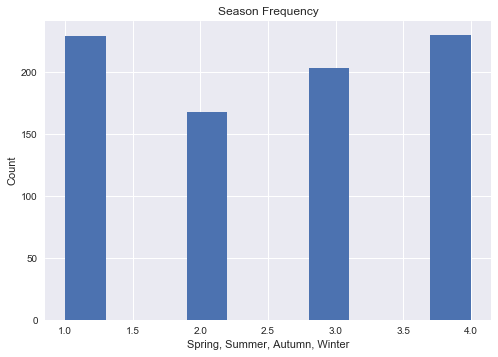

In [19]:
plt.hist(ordersdf.Season)
plt.title("Season Frequency")
plt.xlabel("Spring, Summer, Autumn, Winter")
plt.ylabel("Count")
plt.show()

In [50]:
#put Season, ShipVia, and Freight into their own dataframe
shipdf = pd.concat([ordersdf.Freight, ordersdf.Season, ordersdf.ShipVia], axis=1)

#saving DataFrame as .CSV file to more easily access later, particularly in Hypothesis 3.
shipdf.to_csv(path_or_buf="files/Ship.csv")
shipdf.head(3)

,Freight,Season,ShipVia
0,32.38,2,3
1,11.61,2,1
2,65.83,4,2


In [2]:
#reading in the .csv file
shipdf = pd.read_csv("files/Ship.csv")

#looking at aspects of the DataFrame
shipdf.drop(columns=["Unnamed: 0"], inplace=True)
shipdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 3 columns):
Freight    830 non-null float64
Season     830 non-null int64
ShipVia    830 non-null int64
dtypes: float64(1), int64(2)
memory usage: 19.5 KB


I will now consider whether meteorological winter is a more expensive season for shipping.

In [10]:
#separate Freight by season into two lists (winter and the rest)
winter=[x for x, y in zip(shipdf["Freight"], shipdf["Season"]) if y==4]
notwinter=[x for x, y in zip(shipdf["Freight"], shipdf["Season"]) if y!=4]

Now looking at histograms to compare the distribution of the frequency of the freight costs.

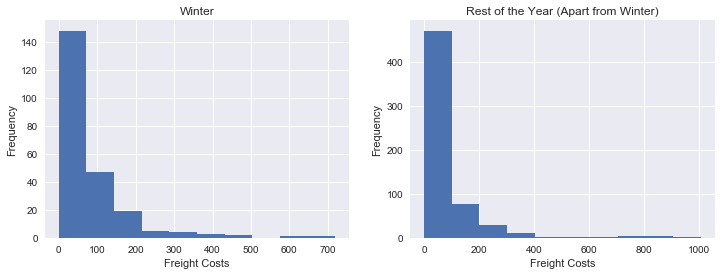

In [52]:
#looking at the distribution of each list
#making axes and a figure to show them side-by-side
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(winter)
plt.title("Winter")
plt.xlabel("Freight Costs")
plt.ylabel("Frequency")

plt.subplot(122)
plt.hist(notwinter)
plt.title("Rest of the Year (Apart from Winter)")
plt.xlabel("Freight Costs")
plt.ylabel("Frequency")

plt.show()

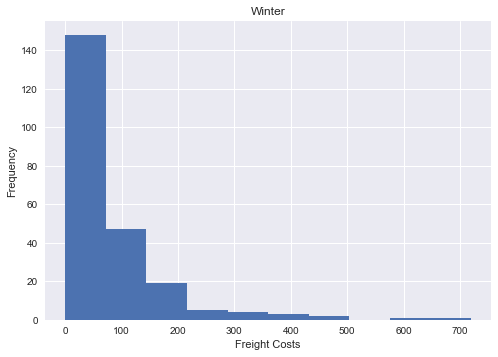

In [11]:
#saving plots individually to use in the PowerPoint presentation

#looking at the distribution of each list
#making axes and a figure to show them side-by-side
plt.hist(winter)
plt.title("Winter")
plt.xlabel("Freight Costs")
plt.ylabel("Frequency")
plt.savefig("graphs/wintryfreight.png")

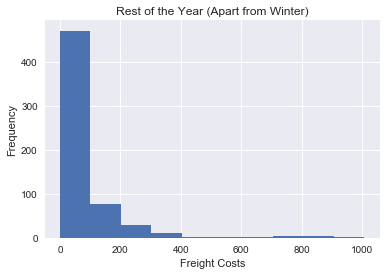

In [12]:
plt.hist(notwinter)
plt.title("Rest of the Year (Apart from Winter)")
plt.xlabel("Freight Costs")
plt.ylabel("Frequency")
plt.savefig("graphs/milderfreight.png")

The distribution of the freight by frequency definitely looks left-skewed.  A log transformation may normalize it.

In [53]:
logWinter = np.log(winter)
logNotWint = np.log(notwinter)

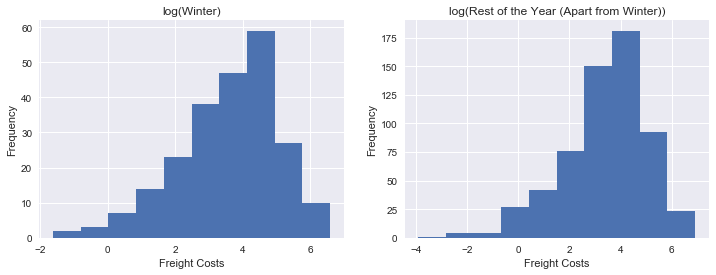

In [54]:
#looking at the distribution of each list, now log-transformed

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(logWinter)
plt.title("log(Winter)")
plt.xlabel("Freight Costs")
plt.ylabel("Frequency")

plt.subplot(122)
plt.hist(logNotWint)
plt.title("log(Rest of the Year (Apart from Winter))")
plt.xlabel("Freight Costs")
plt.ylabel("Frequency")

plt.show()

The log transformation normalized and even skewed the data a little bit more right.

In [55]:
for each in [logWinter, logNotWint]:
    print(stats.kstest(each,'norm'))

KstestResult(statistic=0.8418477074565337, pvalue=0.0)
KstestResult(statistic=0.8074438916319717, pvalue=0.0)


These Kolmogorov-Smirnov test results confirm that the distributions are close to normal, with a p-value of less than .05.

The following four cells save the log-transformed lists as CSV files and then imports them into lists again.

In [28]:
#saving log-transformed data for easy resuming of project
with open("files/logWinter.csv","w") as f:
    writ = csv.writer(f,delimiter="\n")
    writ.writerow(logWinter)

In [29]:
with open("files/logNotWint.csv","w") as f:
    writ = csv.writer(f,delimiter="\n")
    writ.writerow(logNotWint)

In [23]:
#read in lists of log-transformed data
logWinter=[]

with open('files/logWinter.csv') as file:
    CSVreader = csv.reader(file)
    for each in CSVreader:
        if len(each):
            num = float(each[0])
            logWinter.append(num)

In [24]:
logNotWint=[]

with open('files/logNotWint.csv') as file:
    CSVreader = csv.reader(file, delimiter='\n')
    for each in CSVreader:
        if len(each):
            num = float(each[0])
            logNotWint.append(num)

I will now do a one-tailed Welch's t test to test the hypothesis that mean freight costs when shipped in winter are higher than other times of the year.

$H_0: Freight_w \le Freight_n$

$H_1: Freight_w > Freight_n$

In [11]:
onetail(np.array(logWinter),np.array(logNotWint))

0.08572264229176585

In [26]:
0.085722*2

0.171444

In [25]:
stats.ttest_ind(np.array(logWinter),np.array(logNotWint),equal_var=False)

Ttest_indResult(statistic=1.3697770604761548, pvalue=0.17144528458353156)

In [29]:
stats.ttest_ind(np.array(logNotWint),np.array(logWinter),equal_var=False)

Ttest_indResult(statistic=-1.3697770604761548, pvalue=0.17144528458353156)

The p-value is 0.08, which is slightly higher than 0.05, so there is not a significant difference between winter months and non-winter months.

I'll resample and get a normal distribution and then compare effect size using Cohen's $d$ statistic to show the magnitude of difference between the winter and non-winter freight costs.

In [4]:
#create normally distributed lists of sample means
sample_winter = resample(logWinter)
sample_notwint = resample(logNotWint)

In [6]:
#make the normalized resampled means into a sample of a normal continuous random variable
norm_winter = stats.norm.rvs(loc=np.mean(sample_winter), scale=np.std(sample_winter), size=1000, random_state=25)
norm_notwint = stats.norm.rvs(loc=np.mean(sample_notwint), scale= np.std(sample_notwint), size=1000, random_state=25)
#setting random_state so the results are reproducible

In [8]:
Cohen_d(norm_notwint, norm_winter)

0.10933272781189324

Cohen's $d$ statistic shows a very small effect from the wintry season on the price of shipping (`freight`), as it is lower than 0.2 ("small effect").  However, since the one-tailed test found no significant difference, this result is also not significant.

## Hypothesis 3: The Shipping Company has no effect on the shipping costs.
Using `ShipVia` and `Freight`, I will compare the three shipping companies (categorized as 1,2,3 in `ShipVia`) to see what sort of effect size they have on the cost of shipping products (`Freight`).

$H_0: Freight_1 = Freight_2 = Freight_3$

$H_1: Freight_1 \ne Freight_2$

$H_1: Freight_1 \ne Freight_3$

$H_1: Freight_3 \ne Freight_2$

In [14]:
#import previously created table of the Orders/Shipping dataframe
#reading in the .csv file that saved Season, ShipVia and Freight
shipdf = pd.read_csv("files/Ship.csv")

#looking at aspects of the DataFrame
shipdf.drop(columns=["Unnamed: 0"], inplace=True)
shipdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 3 columns):
Freight    830 non-null float64
Season     830 non-null int64
ShipVia    830 non-null int64
dtypes: float64(1), int64(2)
memory usage: 19.5 KB


In [15]:
shipdf.ShipVia.value_counts()

2    326
3    255
1    249
Name: ShipVia, dtype: int64

In [33]:
#put them into three lists, separating out by company 1 2 or 3
shipvia_1 = [x for x, y in zip(shipdf["Freight"], shipdf["ShipVia"]) if y==1]
shipvia_2 = [x for x, y in zip(shipdf["Freight"], shipdf["ShipVia"]) if y==2]
shipvia_3 = [x for x, y in zip(shipdf["Freight"], shipdf["ShipVia"]) if y==3]

In [64]:
print(inspector.get_table_names())#check the table names in Northwind

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'OrderDetail', 'Orders', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


The table is actually called `Shipper`, not "Shippers" like the diagram.  Also, according to the diagram, the two variables of interest are the `ShipperID` and the `CompanyName`.

In [24]:
#getting shipping companies' information from 'Shipper' database
conn = myengine.connect()
shippers = conn.execute('''SELECT Id, CompanyName FROM Shipper;''').fetchall()
shippers

[(1, 'Speedy Express'), (2, 'United Package'), (3, 'Federal Shipping')]

In [25]:
#convert names and id's into dictionary
shipdict = dict()
for each in shippers:
    shipdict[each[0]]=each[1]
shipdict

{1: 'Speedy Express', 2: 'United Package', 3: 'Federal Shipping'}

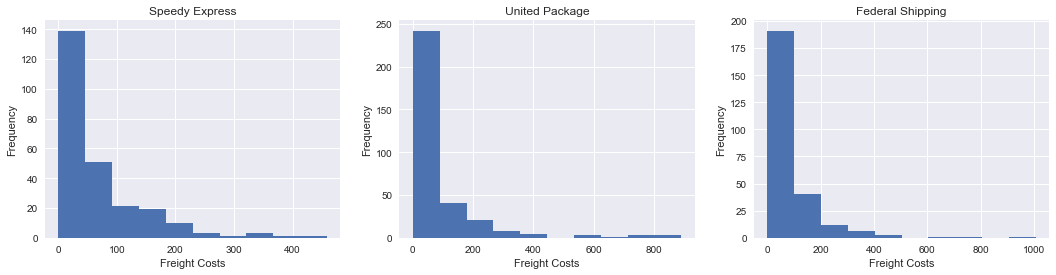

In [68]:
#graph to see how normal distribution looks
plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.hist(shipvia_1)
plt.title(f"{shipdict[1]}")
plt.xlabel("Freight Costs")
plt.ylabel("Frequency")

plt.subplot(132)
plt.hist(shipvia_2)
plt.title(f"{shipdict[2]}")
plt.xlabel("Freight Costs")
plt.ylabel("Frequency")

plt.subplot(133)
plt.hist(shipvia_3)
plt.title(f"{shipdict[3]}")
plt.xlabel("Freight Costs")
plt.ylabel("Frequency")

plt.show()

All three of the distributions look left-skewed.

I'll look at Cohen's $d$ statistic to show the difference in costs between the three shipping companies in pairs: 1 & 2; 2 & 3; and 1 & 3.

In [19]:
#create normally distributed lists of sample means
sample_Ship1 = resample(shipvia_1)
sample_Ship2 = resample(shipvia_2)
sample_Ship3 = resample(shipvia_3)

I will now put the normalized resampled means from each shipping company into the multple comparison `pairwise_tukeyhsd` test.  Since I want to know whether there's any significant difference, it will be a two-tailed test.

In [31]:
#resample returns a list but I need numpy arrays
shipsamples = np.concatenate([np.array(sample_Ship1),np.array(sample_Ship2),np.array(sample_Ship3)])
shipnames = [shipdict[1]]*len(sample_Ship1) + [shipdict[2]]*len(sample_Ship2) + [shipdict[3]]*len(sample_Ship3)
print(pairwise_tukeyhsd(shipsamples,shipnames,0.05))

       Multiple Comparison of Means - Tukey HSD,FWER=0.05       
     group1          group2     meandiff  lower    upper  reject
----------------------------------------------------------------
Federal Shipping Speedy Express -12.0404 -22.3945 -1.6864  True 
Federal Shipping United Package -0.8166  -11.1707  9.5374 False 
 Speedy Express  United Package 11.2238   0.8697  21.5779  True 
----------------------------------------------------------------


The `pairwise_tukeyhsd` test from statsmodels multiple comparisons (`multicomp`) package shows that Federal Shipping and United Package are not significantly different from each other (`reject` is `False`), but that there is a significant difference between each of them and Speedy Express.

In [ ]:
#make the normalized resampled means into a sample of a normal continuous random variable
norm_Ship1 = stats.norm.rvs(loc=np.mean(sample_Ship1), scale=np.std(sample_Ship1), size=1000, random_state=25)
norm_Ship2 = stats.norm.rvs(loc=np.mean(sample_Ship2), scale=np.std(sample_Ship2), size=1000, random_state=25)
norm_Ship3 = stats.norm.rvs(loc=np.mean(sample_Ship3), scale=np.std(sample_Ship3), size=1000, random_state=25)
#setting random_state so the results are reproducible

In [79]:
# creating pairs to compare effect size:
pairs = [[norm_Ship1, norm_Ship2],[norm_Ship1, norm_Ship3],[norm_Ship2, norm_Ship3]]

print("The companies are identified as follows:")
print(shipdict)

#running for loop to print out information
for idx, pair in enumerate(pairs):
    if idx ==0:
        number = "first"
        pair1 = shipdict[1]
        pair2 = shipdict[2]
    elif idx==1:
        number="second"
        pair1=shipdict[1]
        pair2=shipdict[3]
    else:
        number="third"
        pair1=shipdict[2]
        pair2 = shipdict[3]
        
    smallBreak = (0.2+0.5)/2
    largeBreak = (0.5+0.8)/2
    
    d = abs(Cohen_d(pair[0],pair[1]))
    
    if d<=smallBreak: # around 0.2 is a small effect size
        adjective="small"
    elif d<=largeBreak: # around 0.5 is a medium effect size
        adjective = "medium"
    else: # around 0.8 is a large effect size
        adjective = "large"
    
    print(f"The {number} pair of Shipping Companies ({pair1} and {pair2}) have a {adjective} effect size: {d}")

The companies are identified as follows:
{1: 'Speedy Express', 2: 'United Package', 3: 'Federal Shipping'}
The first pair of Shipping Companies (Speedy Express and United Package) have a large effect size: 0.7976501268118755
The second pair of Shipping Companies (Speedy Express and Federal Shipping) have a large effect size: 0.7042240079533493
The third pair of Shipping Companies (United Package and Federal Shipping) have a small effect size: 0.04715228375178642


The small effect size when comparing `ShipVia` companies 2 and 3 (United Package and Federal Shipping) indicates that there is almost no difference between them that affect the price of shipping (the `Freight` variable).  As is known from the t test results, any difference between United Package and Federal Shipping is not significant.

Contrastingly, there is a relatively large effect size when comparing `ShipVia` company 1 (Speedy Express) to either 2 or 3 (United Package and Federal Shipping, respectively), which means the price of shipping is affected when using company 1 versus 2 or 3.

I will now combine companies 2 & 3 into one dataset to compare directly against company 1.

In [34]:
#combining shipvia_2 and shipvia_3
shipvia_23 = shipvia_2+shipvia_3
shipvia_23[-1]

14.01

In [47]:
#comparing combined 2&3 to 1 with a two-tailed Welch's t test
stats.ttest_ind(np.array(shipvia_23), np.array(shipvia_1))

Ttest_indResult(statistic=2.143417006972789, pvalue=0.03237038381222644)

If I make it a two-tailed test where $H_0: shipvia_{23} = shipvia_1$ and $H_1: shipvia_{23} \ne shipvia_1$ , then the p-value would be 0.032.  This is slightly less than the alpha 0.05 so the null hypothesis is rejected and the difference remains significant between company 1 and the combined data of companies 2 and 3.

#### Creating a Histogram Comparing Shipping Companies

In [81]:
print(len(shipvia_23)/len(shipvia_1))

2.3333333333333335


In [82]:
2.3333333*3

6.999999900000001

The `ShipVia` for combined companies 2 and 3 is 2-1/3 (or seven-thirds) times larger than company 1.  To get a reasonably comparable graph using histograms, the number of bins should be adjusted proportionately, with a ratio of 3:7.

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")

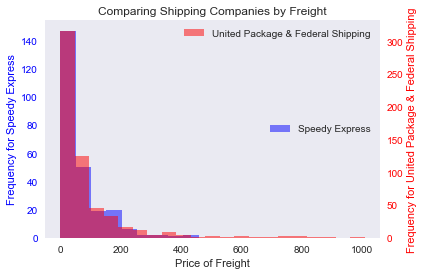

In [76]:
# now comparing only shipvia_1 to shipvia_2 and shipvia_3 combined

#compare both distributions with frequency on different scales
#since shipvia_23 has about twice as many records as shipvia_1

fig, ax1 = plt.subplots()

ax1.hist(shipvia_1, alpha=0.5, label=shipdict[1], color="blue", bins=9)
ax1.set_xlabel("Price of Freight")
ax1.set_ylabel(f'Frequency for {shipdict[1]}', color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.legend(loc=5)
plt.grid(b=None)

ax2 = ax1.twinx() #creating a second axes that shares the x-axis but has a different scale for the y-axis
ax2.hist(shipvia_23, alpha = 0.5, label=shipdict[2]+" & "+shipdict[3], color="red", bins=21)
ax2.set_ylabel(f'Frequency for {shipdict[2]} & {shipdict[3]}', color="red")# x label was already set in ax1, and they share the x-axis
ax2.tick_params(axis='y', labelcolor="red")
ax2.legend(loc=0)

plt.grid(b=None)
plt.title("Comparing Shipping Companies by Freight")
#plt.show()

plt.savefig("graphs/compShipvia.png")

The above histogram shows `ShipVia` for companies 2 and 3 (United Package and Federal Shipping, respectively) and company 1 (Speedy Express) to have very similar distributions, with much overlap at the lower values of `Freight`.  Higher values (above 250 or so) are less common or non-existent in company 1 compared to companies 2 or 3 so perhaps this difference accounts for the large effect size noted above.  That is, maybe when shipping with company 2 or 3, it is slightly more likely to have a significantly higher freight cost.

## Hypothesis 4: Orders for products that are in stock or have not been discontinued have higher totals than those that are out of stock or are discontinued
$H_0: Cost_i \le Cost_0$  (where $Cost$ is the total cost of each order that contains an item in stock $i$ or discontinued/out-of-stock $0$)

$H_1: Cost_i > Cost_0$

Finding effect size between prices (totals) of orders that are in stock & not discontinued compared to out of stock & discontinued orders by looking at OrderId from OrderDetails because that has the discount and quantity, which are needed to get the total amount of money spent on that product in a particular order.

In [15]:
cols = inspector.get_columns("Product")
pdcols = []
for col in cols:
    pdcols.append(col['name'])

In [16]:
#Product columns
pdcols

['Id',
 'ProductName',
 'SupplierId',
 'CategoryId',
 'QuantityPerUnit',
 'UnitPrice',
 'UnitsInStock',
 'UnitsOnOrder',
 'ReorderLevel',
 'Discontinued']

In [17]:
cols = inspector.get_columns("OrderDetail")
odcols = []
for col in cols:
    odcols.append(col['name'])

In [18]:
#OrderDetail columns
odcols

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [19]:
#joining OrderDetail with Product to get dataframe of order info listed by individual product with the in stock
#or discontinued flags (UnitsInStock and Discontinued, respectively)
ordersOOSorDisc = conn.execute('''SELECT OrderDetail.*, Product.Id AS ProdId, Product.Discontinued,
Product.UnitsInStock
FROM OrderDetail
  JOIN Product
    ON ProdId = OrderDetail.ProductId''').fetchall()

In [20]:
#combine lists of columns into appropriate names:
sdcols = odcols.copy()
sdcols.append("ProductId2")
sdcols.append(pdcols[-1])
sdcols.append(pdcols[-4])
sdcols

['Id',
 'OrderId',
 'ProductId',
 'UnitPrice',
 'Quantity',
 'Discount',
 'ProductId2',
 'Discontinued',
 'UnitsInStock']

In [21]:
ordersOOSDdf = pd.DataFrame(ordersOOSorDisc, columns=sdcols)
ordersOOSDdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 9 columns):
Id              2155 non-null object
OrderId         2155 non-null int64
ProductId       2155 non-null int64
UnitPrice       2155 non-null float64
Quantity        2155 non-null int64
Discount        2155 non-null float64
ProductId2      2155 non-null int64
Discontinued    2155 non-null int64
UnitsInStock    2155 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 151.6+ KB


In [25]:
ordersOOSDdf.drop(columns=["ProductId2"], inplace=True)
ordersOOSDdf.head()

,Unnamed: 0,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discontinued,UnitsInStock
0,0,10248/11,10248,11,14.0,12,0.0,0,22
1,1,10248/42,10248,42,9.8,10,0.0,1,26
2,2,10248/72,10248,72,34.8,5,0.0,0,14
3,3,10249/14,10249,14,18.6,9,0.0,0,35
4,4,10249/51,10249,51,42.4,40,0.0,0,20


In [17]:
#calculate new columns: price and DiscontinuedOrOutOfStock, to add to Dataframe
ordersOOSDdf["NotInStock"] = [1 if(discontinue == 1 or inStock==0) else 0 for discontinue, inStock in zip(ordersOOSDdf.Discontinued, ordersOOSDdf.UnitsInStock)]

In [35]:
ordersOOSDdf.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discontinued,UnitsInStock,NotInStock
0,10248/11,10248,11,14.0,12,0.0,0,22,0
1,10248/42,10248,42,9.8,10,0.0,1,26,1
2,10248/72,10248,72,34.8,5,0.0,0,14,0
3,10249/14,10249,14,18.6,9,0.0,0,35,0
4,10249/51,10249,51,42.4,40,0.0,0,20,0


In [18]:
#For curiosity, how many UnitsInStock are 0 and have been Discontinued?
ordersOOSDdf.query('UnitsInStock<1').Discontinued.value_counts()

1    109
0     51
Name: Discontinued, dtype: int64

228 Id's have been discontinued and 160 have 0 in stock.  Of those with 0 in stock, 109 have been discontinued and 51 have not which makes (228+51=) 279 total not in stock or discontinued, out of 2155 records.

In [49]:
#creating a function to use in list comprehension
def calcPrice(mydisc, myqty, myunitprice):
    return (1-mydisc)*myunitprice*myqty #the final price at which the items were sold

In [51]:
#adding a column for the price for each product for each order, using UnitPrice, Quantity and Discount
ordersOOSDdf["Price"] = [calcPrice(disc, qty, unitprice) for disc,qty,unitprice in zip(ordersOOSDdf.Discount, ordersOOSDdf.Quantity, ordersOOSDdf.UnitPrice)]

In [53]:
ordersOOSDdf.head(10)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discontinued,UnitsInStock,NotInStock,Price
0,10248/11,10248,11,14.0,12,0.00,0,22,0,168.00
1,10248/42,10248,42,9.8,10,0.00,1,26,1,98.00
2,10248/72,10248,72,34.8,5,0.00,0,14,0,174.00
3,10249/14,10249,14,18.6,9,0.00,0,35,0,167.40
4,10249/51,10249,51,42.4,40,0.00,0,20,0,1696.00
5,10250/41,10250,41,7.7,10,0.00,0,85,0,77.00
6,10250/51,10250,51,42.4,35,0.15,0,20,0,1261.40
7,10250/65,10250,65,16.8,15,0.15,0,76,0,214.20
8,10251/22,10251,22,16.8,6,0.05,0,104,0,95.76
9,10251/57,10251,57,15.6,15,0.05,0,36,0,222.30


In [57]:
#saving as .CSV for easy resuming later:
ordersOOSDdf.to_csv(path_or_buf="files/OrdersStockDisc.csv")

In [3]:
ordersOOSDdf = pd.read_csv("files/OrdersStockDisc.csv")
ordersOOSDdf.drop(columns=["Unnamed: 0"], inplace=True)
ordersOOSDdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 10 columns):
Id              2155 non-null object
OrderId         2155 non-null int64
ProductId       2155 non-null int64
UnitPrice       2155 non-null float64
Quantity        2155 non-null int64
Discount        2155 non-null float64
Discontinued    2155 non-null int64
UnitsInStock    2155 non-null int64
NotInStock      2155 non-null int64
Price           2155 non-null float64
dtypes: float64(3), int64(6), object(1)
memory usage: 168.4+ KB


In [4]:
ordersOOSDdf.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discontinued,UnitsInStock,NotInStock,Price
0,10248/11,10248,11,14.0,12,0.0,0,22,0,168.0
1,10248/42,10248,42,9.8,10,0.0,1,26,1,98.0
2,10248/72,10248,72,34.8,5,0.0,0,14,0,174.0
3,10249/14,10249,14,18.6,9,0.0,0,35,0,167.4
4,10249/51,10249,51,42.4,40,0.0,0,20,0,1696.0


In [5]:
#separate out each NotInStock, just with keeping track of Price
unavail = [total for total, notstock in zip(ordersOOSDdf.Price, ordersOOSDdf.NotInStock) if notstock]
available = [total for total, notstock in zip(ordersOOSDdf.Price, ordersOOSDdf.NotInStock) if not notstock]

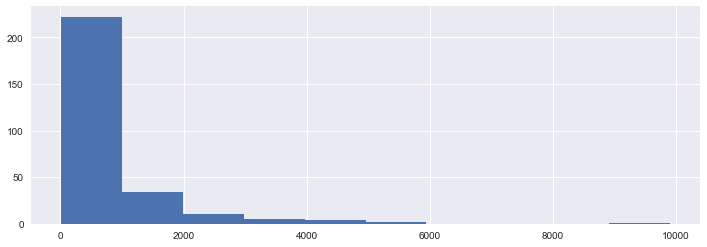

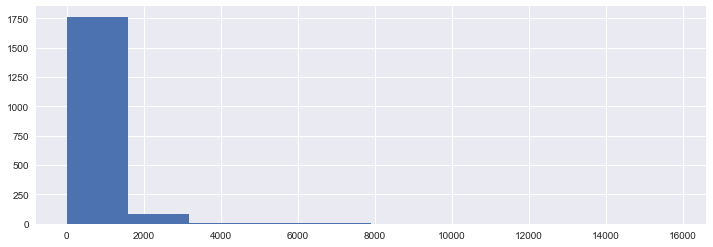

In [18]:
for each in [unavail, available]:
    plt.figure(figsize=(12,4))
    plt.hist(each)
    plt.show()

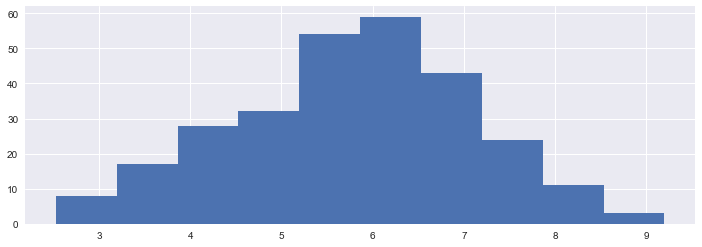

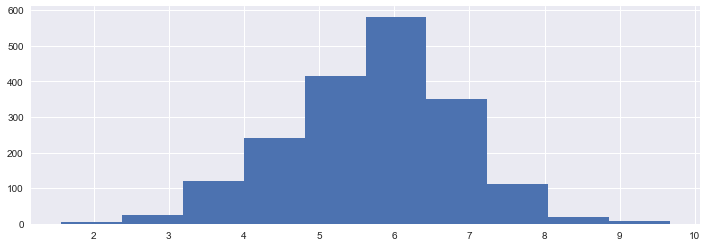

In [79]:
#trying to graph the log
lunavail = np.log(unavail)
lavailable = np.log(available)
for each in [lunavail, lavailable]:
    plt.figure(figsize=(12,4))
    plt.hist(each)
    plt.show()

Taking the logarithm of the two datasets gives normalized-looking data for both.

I will now do a one-tailed test to see whether there are higher prices in discontinued/out-of-stock (unavailable) items or whether customers spend less or the same on regular (available) items.

$H_0: price_{unavail} \le price_{available}$

$H_1: price_{unavail} > price_{available}$

In [15]:
#I'm looking at whether the prices of "unavailable" items are significantly higher
#so the unavailable data is the first argument
onetail(np.array(unavail),np.array(available))

0.01583388580101075

In [8]:
stats.ttest_ind(np.array(available), np.array(unavail),equal_var=False)

Ttest_indResult(statistic=-2.1573912832954427, pvalue=0.031667771602021645)

`ttest_ind` is doing a two-tail test so dividing its resulting p-value of 0.03 by 2 gives 0.015 for a one-tail test. Then, the null hypothesis is rejected, since that p-value is less than the alpha of 0.05.

Then, calculating effect size with the Cohen's *d* function.

In [22]:
#calculate effect size
Cohen_d(lunavail, lavailable)

0.06598858429072513

.066 is a pretty small effect size so this means that whether a product is out of stock and/or has been discontinued barely affects the price paid for it

#### Creating a graph to compare how much is paid for products

In [29]:
#creating new column for graph: UnitCost = Price/Quantity
ordersOOSDdf["UnitCost"] = [(price/qty) for qty,price in zip(ordersOOSDdf.Quantity,ordersOOSDdf.Price)]

In [31]:
ordersOOSDdf.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discontinued,UnitsInStock,NotInStock,Price,UnitCost
0,10248/11,10248,11,14.0,12,0.0,0,22,0,168.0,14.0
1,10248/42,10248,42,9.8,10,0.0,1,26,1,98.0,9.8
2,10248/72,10248,72,34.8,5,0.0,0,14,0,174.0,34.8
3,10249/14,10249,14,18.6,9,0.0,0,35,0,167.4,18.6
4,10249/51,10249,51,42.4,40,0.0,0,20,0,1696.0,42.4


In [36]:
#creating two sets of data to plot on the same scatterplot axes
#unit price paid vs quantity

costavailable,costunavail,Qavailable,Qunavail = [],[],[],[]
for idx, notstock in enumerate(ordersOOSDdf.NotInStock):
    qty = ordersOOSDdf.iloc[idx,4]
    cost = ordersOOSDdf.iloc[idx,-1]
    
    if notstock:#if an item is discontinued or out of stock
        Qunavail.append(qty)
        costunavail.append(cost)
    else:
        Qavailable.append(qty)
        costavailable.append(cost)

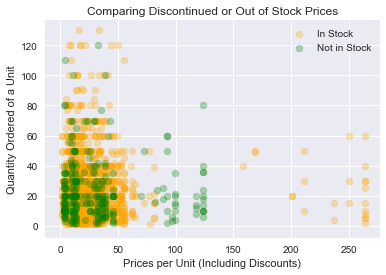

In [43]:
#unit price paid on the x-axis and quantity on the y-axis

fig, ax1 = plt.subplots()

ax1.scatter(costavailable, Qavailable, alpha=0.3, label="In Stock", color="orange")
ax1.scatter(costunavail, Qunavail, alpha=0.3, label="Not in Stock", color="green")
ax1.legend()

plt.xlabel("Prices per Unit (Including Discounts)")
plt.ylabel("Quantity Ordered of a Unit")
plt.title("Comparing Discontinued or Out of Stock Prices")
#plt.show()

plt.savefig("graphs\outofstock.png")

## Unavailable Products and Discounts
When working on my presentation, I raised the idea that discontinued or out-of-stock items don't need discounts, so I wondered how many products that would affect.

In [5]:
#how many of those are currently being sold at a discount?
ordersOOSDdf.query('Discontinued>0').Discount.value_counts()

0.00    142
0.10     21
0.05     20
0.25     20
0.20     14
0.15     11
Name: Discount, dtype: int64

In [7]:
ordersOOSDdf.query('UnitsInStock<1').Discount.value_counts()

0.00    91
0.05    21
0.10    17
0.25    15
0.20    11
0.15     5
Name: Discount, dtype: int64

It looks like most already are not sold with discounts.  There is a relatively small amount sold with discounts so more data would be necessary to actually make any determination about whether it could be worth Northwind's while to sell all discontinued or out-of-stock items at full price.